## Data Analysis

In [2]:
import pandas as pd
from datetime import datetime

In [3]:
# read data from parquet file
combined_data_df=pd.read_parquet("combined_data.parquet")

In [20]:
import matplotlib.pyplot as plt



In [27]:
combined_data_df[combined_data_df["Income"] > 200000].shape


(5516, 28)

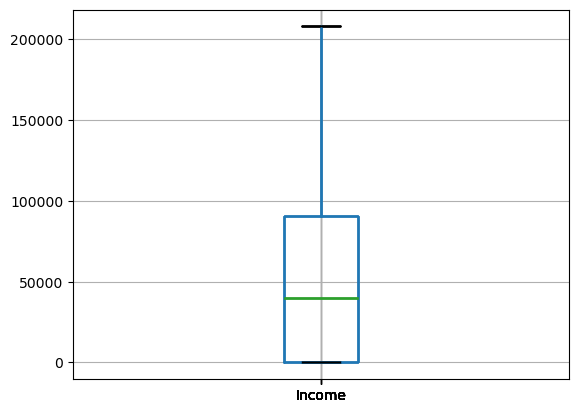

In [21]:
# combined_data_df.describe()
# print(combined_data_df.isnull().sum())
boxplt = combined_data_df.boxplot(column = "Income")

boxplt.plot()

plt.show()



### What is the average number of cars per household?

In [4]:
cars_per_household = combined_data_df.groupby("HH_ID").size()

In [5]:
average_cars_per_household = cars_per_household.mean()

print(f"The average number of cars per household is: {average_cars_per_household}")

The average number of cars per household is: 3.8088266642304647


### How many cars are there by model year?

In [6]:
cars_by_model_year = combined_data_df[["CAR_ID","Model Year"]].groupby("Model Year")\
.agg(car_count=pd.NamedAgg(column="CAR_ID",aggfunc='count')).reset_index()
cars_by_model_year.style.hide(axis='index')

Model Year,car_count
1952,2523
1953,2513
1954,2588
1955,2517
1956,2517
1957,2496
1958,2583
1959,2513
1960,2492
1961,2499


### How many cars are there by make?

In [7]:
cars_by_make = combined_data_df[["CAR_ID","Make"]].groupby("Make")\
.agg(car_count=pd.NamedAgg(column="CAR_ID",aggfunc='count'))

In [8]:
print(cars_by_make)

               car_count
Make                    
Manufacturer1      99822
Manufacturer2     100079
Manufacturer3     100046
Manufacturer4      34839
Manufacturer5      34872
Manufacturer6      65344
Manufacturer7      65295


### Which cars are the safest?  What variables did you consider to define “safe”? 

In [28]:
# I am hypothesizing that a car(Make, Model Year, Body Style) 
# can be considered "safe" if it has Vehicle Safety Discount 
# provided and has no Claim payouts

safe_car=combined_data_df[(combined_data_df["Vehicle Safety Discount"]==1) \
& (combined_data_df["Claim Payout"]==0)] \
[["Model Year","Make","Body Style"]]

In [29]:
# get the count of each "safe car"(Make, Model Year, Body Style) and sort them by count in descending order and display the data

safe_car1=safe_car.groupby(["Model Year","Make","Body Style"])\
.agg(safe_car_count=pd.NamedAgg(column="Body Style",aggfunc='count'))\
.sort_values(by='safe_car_count',ascending=False).head(5)\
.reset_index()
safe_car1.style.hide(axis='index')

Model Year,Make,Body Style,safe_car_count
2021,Manufacturer6,SUV,551
2024,Manufacturer3,SUV,538
2022,Manufacturer7,SUV,537
2020,Manufacturer7,SUV,535
2023,Manufacturer7,SUV,528


### Which states have the largest households (defined as number of customers in a household)?

In [30]:
group_df = combined_data_df.groupby(["State", "HH_ID"]) \
.agg(large_household=pd.NamedAgg(column="CUST_ID",aggfunc='count'))

max_house_count_per_state = group_df.groupby("State")["large_household"].max().reset_index()

In [31]:
from IPython.display import display
max_count=max_house_count_per_state['large_household'].max()
display(max_house_count_per_state[max_house_count_per_state['large_household']==max_count]
.style.hide(axis='index'))

State,large_household
AK,8
AZ,8
GA,8
HI,8
ID,8
IN,8
KS,8
KY,8
MI,8
MN,8


### How many active households are there as of 1/1/2021?

In [32]:
def date_format_correction(df, column, format = "%m/%d/%y"):

    # correct the date conversion pandas is doing to prevent invalid dates(future date)
    
    df[column] = pd.to_datetime(df[column], format = format) \
    .apply(lambda x: x if x.year < datetime.now().year else x.replace(year = x.year-100))

    return df[column]

In [33]:
# correct the date conversion pandas is doing to prevent invalid HH start dates(future date)

combined_data_df["HH Start Date"] = date_format_correction(combined_data_df, "HH Start Date", "%m/%d/%y")

In [35]:
num_of_active_HHs = combined_data_df[(combined_data_df["Active HH"] == 1) \
& (combined_data_df["HH Start Date"] <= '01/01/2021') ]["HH_ID"].nunique()

In [36]:
print(f"There are {num_of_active_HHs} active households as of 1/1/2021")

There are 96421 active households as of 1/1/2021


### What is the average age of customers?

In [37]:
combined_data_df["Date of Birth"] = date_format_correction(combined_data_df, "Date of Birth", "%m/%d/%y")

In [38]:
def calculate_age(birthdate):
    #calculate age by subtracting DOB with current date and dividing by 365 days
    today = datetime.today()
    return ((pd.to_datetime(today) - pd.to_datetime(birthdate)).days)/365

In [39]:
combined_data_df['Age'] = combined_data_df['Date of Birth'].apply(calculate_age)

In [40]:
print(f"Average Age of Customers is {combined_data_df['Age'].mean()} yrs")

Average Age of Customers is 51.0913454230105 yrs


### How much does age vary by region?

In [41]:

import matplotlib.pyplot as plt
# Create age groups
bins = [16, 18, 25, 35, 45, 55, 65, 100]
labels = ['16-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']
combined_data_df['Age Group'] = pd.cut(combined_data_df['Age'], bins=bins, labels=labels, right=False)

# Group data by 'State' and 'Age Group' and count the number of customers
age_group_by_state = combined_data_df.groupby(['State', 'Age Group']) \
.agg(cust_count=pd.NamedAgg(column="CUST_ID",aggfunc='count')) \
.reset_index()


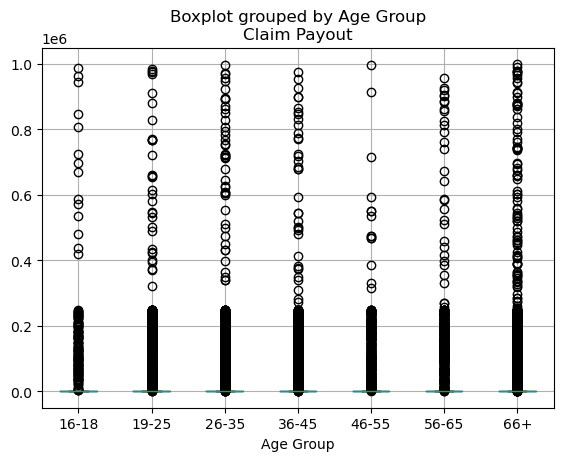

In [45]:
boxplt = combined_data_df.boxplot(column = "Claim Payout", by = "Age Group")

boxplt.plot()

plt.show()

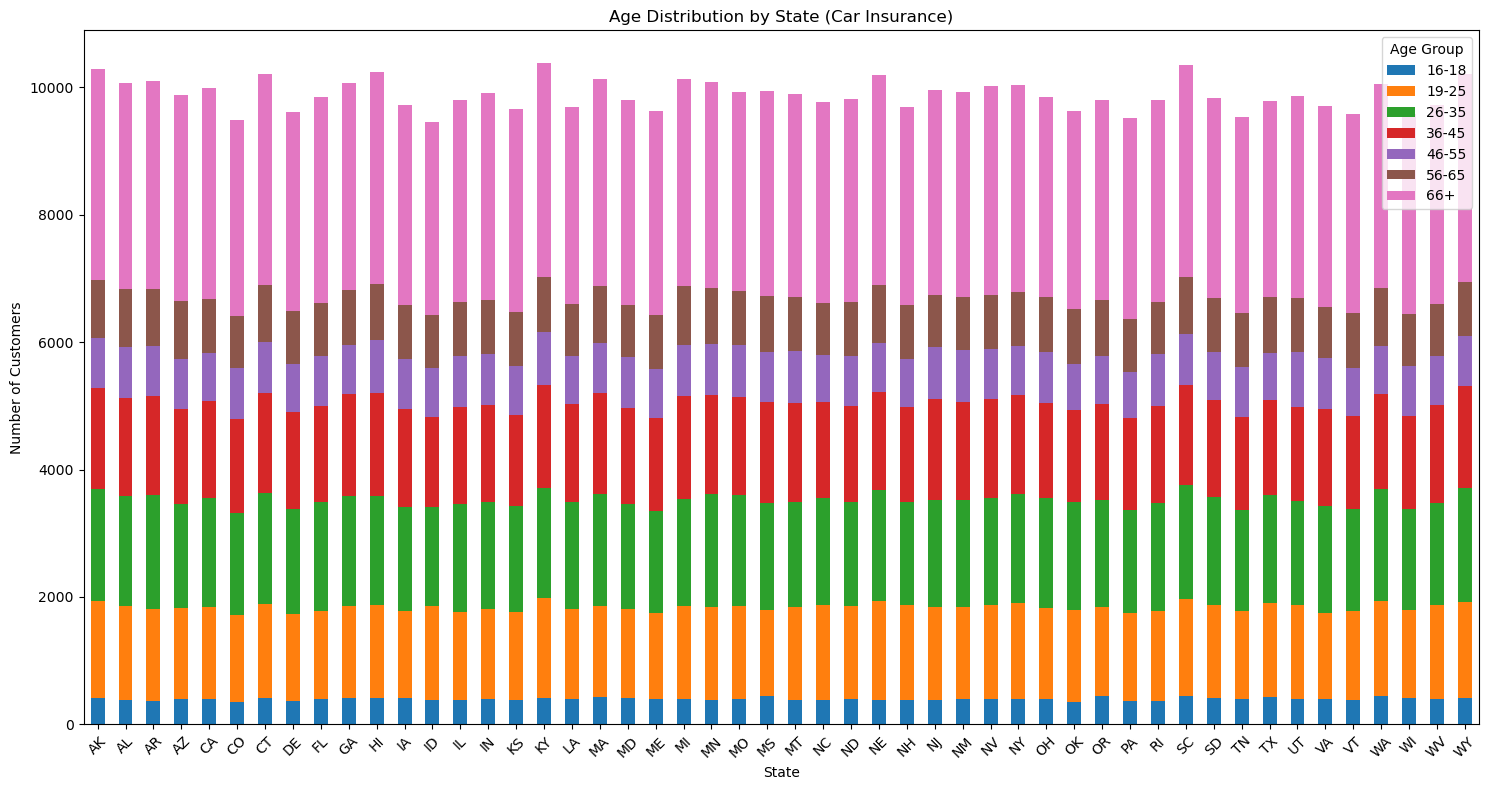

In [26]:
# Pivot the table to have states as rows and age groups as columns for stacked bar chart
age_group_pivot = age_group_by_state.pivot(index='State', columns='Age Group', values='cust_count').fillna(0)

# Plot the bar graph
age_group_pivot.plot(kind='bar', stacked=True, figsize=(15, 8))

# Add labels and title
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.title('Age Distribution by State (Car Insurance)')
plt.xticks(rotation=45)
plt.legend(title='Age Group')

# Show the plot
plt.tight_layout()
plt.show()

### Which age group has the most expensive claims? 

In [41]:
# Group by 'Age Group' and sum the claim payouts
claims_by_age_group = combined_data_df[combined_data_df["Claim Payout"]>0].groupby(['Age Group']).agg({"Claim Payout":"mean"})

# Identify the age group with the highest total claims
most_expensive_claims_group = claims_by_age_group.idxmax()
most_expensive_claims_value = claims_by_age_group.max()

# Display the result
print(f"The age group with the most expensive claims is {most_expensive_claims_group[0]} with total average claim payout value of {most_expensive_claims_value[0]}.")

The age group with the most expensive claims is 16-18 with total average claim payout value of 178385.43971631204.
